In [15]:
# Installing required libraries for generating QR codes and building the GAN
# !pip install qrcode[pil] tensorflow numpy pillow matplotlib

# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import qrcode

# TensorFlow and Keras imports
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Reshape, LeakyReLU, BatchNormalization, Conv2DTranspose
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Import necessary layers and optimizers
# Write your code here 
from tensorflow.keras.layers import Input, Flatten, Dropout, Conv2D
from tensorflow.keras.optimizers import Adam



In [16]:
# Create directory to store training QR codes
os.makedirs('qr_codes/train', exist_ok=True)

os.makedirs('qr_codes/val', exist_ok=True)



In [17]:
# Define a function to generate QR codes with embedded messages and save them as image files.
def generate_qr_code(data, filename):
    qr = qrcode.QRCode(version=1, box_size=10, border=5)
    qr.add_data(data)
    qr.make(fit=True)
    img = qr.make_image(fill_color="black", back_color="white")
    img.save(filename)

# Generate a set of 80 training QR codes
for i in range(80):
    generate_qr_code(f"Message {i}", f"qr_codes/train/qr_code_{i}.png")


# Generate a set of 20 validation QR codes
for i in range(20):
    generate_qr_code(f"Validation Message {i}", f"qr_codes/val/qr_code_val_{i}.png")

In [18]:
# Verify if the QR code images have successfully generated
# by counting the number of images in the training and validation directories.
train_images = os.listdir('qr_codes/train')
val_images = os.listdir('qr_codes/val')

# Print the number of generated training and validation images
print("Number of training QR codes:", len(train_images))
print("Number of validation QR codes:", len(val_images))



Number of training QR codes: 80
Number of validation QR codes: 20


In [19]:
# Define a function to load images from a directory, resize them, and normalize pixel values for better GAN performance.
def load_images(image_dir, target_size=(100, 100)):
    images = []
    filenames = os.listdir(image_dir)
    for filename in filenames:
        img = load_img(os.path.join(image_dir, filename), target_size=target_size)
        img_array = img_to_array(img)
        images.append(img_array)
    return np.array(images)

# Load the training and validation images
train_images = load_images('qr_codes/train')
val_images = load_images('qr_codes/val')

# Normalize the images to the range [-1, 1]
train_images = (train_images - 127.5) / 127.5
val_images = (val_images - 127.5) / 127.5

# Print the shape of the training and validation images
print("Training images shape:", train_images.shape)
print("Validation images shape:", val_images.shape)


Training images shape: (80, 100, 100, 3)
Validation images shape: (20, 100, 100, 3)


In [20]:
# Define and construct the generator model for the GAN.
# The model takes random noise as input and generates QR code images.
def build_generator():
    model = Sequential()
    
    # Initial dense layer to project the input noise into a higher-dimensional space
    model.add(Dense(256 * 25 * 25, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((25, 25, 256)))  # Reshape to a 3D tensor
    
    # First upsampling layer: Upsample to 50x50
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())

    # Second upsampling layer: Upsample to 100x100
    model.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())

    # Output layer: Generates a 100x100 image with 3 color channels
    model.add(Conv2DTranspose(3, (4, 4), activation='tanh', padding='same'))
    
    return model

# Build the generator model and display the model's architecture

generator = build_generator()
generator.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 160000)         │    16,160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 160000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 50, 50, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 50, 50, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 100, 100, 64)   │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 100, 100, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 100, 100, 3)    │         3,075 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,819,395 (64.16 MB)

 Trainable params: 16,819,011 (64.16 MB)

 Non-trainable params: 384 (1.50 KB)

In [21]:
# Define and construct the discriminator model for the GAN.
# The model classifies images as real or fake QR codes.
def build_discriminator():
    model = Sequential()
    
    # First convolutional layer: 64 filters, 3x3 kernel, same padding
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(100, 100, 3)))
    model.add(LeakyReLU(alpha=0.2))  # Leaky ReLU activation
    model.add(Dropout(0.4))  # Dropout for regularization
    
    # Second convolutional layer: 128 filters, 3x3 kernel, downsampled by 2
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    # Third convolutional layer: 256 filters, 3x3 kernel, downsampled by 2
    model.add(Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    
    # Flatten the output for the final dense layer
    model.add(Flatten())
    
    # Output layer: Single neuron for binary classification with sigmoid activation
    model.add(Dense(1, activation='sigmoid'))
    
    return model

# Build, compile the discriminator model with binary crossentropy loss and Adam optimizer, and display its architecture
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
discriminator.summary()




Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 160000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │       160,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 530,817 (2.02 MB)

 Trainable params: 530,817 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.optimizers import Adam

def build_gan(generator, discriminator, z_dim=100):
    discriminator.trainable = False  # freeze discriminator

    # define GAN input (latent vector)
    gan_input = Input(shape=(z_dim,))

    # generate fake image
    fake_image = generator(gan_input)

    # get discriminator output (real/fake)
    gan_output = discriminator(fake_image)

    # build combined GAN model
    gan = Model(gan_input, gan_output)

    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    return gan

# Example usage (assuming generator and discriminator already exist)
gan = build_gan(generator, discriminator)
gan.summary()


Model: "functional_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 100, 100, 3)    │    16,819,395 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 1)              │       530,817 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,350,212 (66.19 MB)

 Trainable params: 16,819,011 (64.16 MB)

 Non-trainable params: 531,201 (2.03 MB)

In [25]:
# Directory for saving model checkpoints
checkpoint_dir = 'gan_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Define a training function for the GAN, which alternates between
# training the discriminator on real and fake images and training the generator.
def train_gan(generator, discriminator, gan, epochs, batch_size, checkpoint_interval=100):
    for epoch in range(epochs):
        # Train the discriminator
        idx = np.random.randint(0, train_images.shape[0], batch_size)  # Randomly select real images
        real_images = train_images[idx]

        noise = np.random.normal(0, 1, (batch_size, 100))  # Generate random noise
        fake_images = generator.predict(noise)  # Generate fake images from noise

        # Train the discriminator on real and fake images
        d_loss_real = discriminator.train_on_batch(real_images, np.ones((batch_size, 1)))  # Real images labeled as 1
        d_loss_fake = discriminator.train_on_batch(fake_images, np.zeros((batch_size, 1)))  # Fake images labeled as 0
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)  # Average loss

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, 100))  # Generate new noise
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))  # Label as 1 to fool the discriminator

        # Print the progress every 100 epochs
        if epoch % 100 == 0:
            print(f"{epoch} [D loss: {d_loss[0]} | D acc: {d_loss[1]}] [G loss: {g_loss}]")
        
        # Save the model every checkpoint_interval epochs
        if epoch % checkpoint_interval == 0:
            generator.save(os.path.join(checkpoint_dir, f"generator_epoch_{epoch}.h5"))
            discriminator.save(os.path.join(checkpoint_dir, f"discriminator_epoch_{epoch}.h5"))

# Start training the GAN with 5000 epochs and a batch size of 32
np.random.seed(42)



In [26]:
# Function to generate and save QR codes from the trained generator
def generate_and_save_qr_codes(generator, n_samples):
    # Generate noise as input for the generator
    noise = np.random.normal(0, 1, (n_samples, 100))
    
    # Use the generator to create fake images (QR codes)
    generated_images = generator.predict(noise)
    
    # Rescale images from [-1, 1] to [0, 1] for proper display and saving
    generated_images = 0.5 * generated_images + 0.5
    
    # Ensure the output directory exists
    os.makedirs('qr_codes/generated', exist_ok=True)
    
    # Save each generated QR code as an image
    for i in range(n_samples):
        plt.imshow(generated_images[i])
        plt.axis('off')  # Turn off the axis for a cleaner look
        plt.savefig(f"qr_codes/generated/qr_code_{i}.png")
        plt.close()  # Close the figure to prevent memory overflow

# Generate 10 QR codes using the trained generator

generate_and_save_qr_codes(generator, n_samples=10)




1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


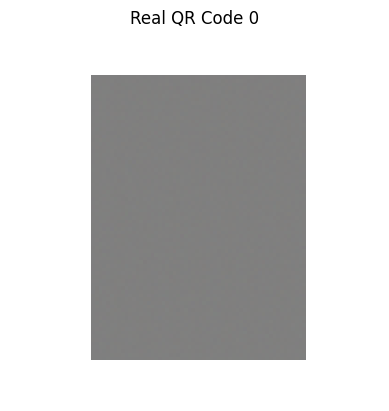

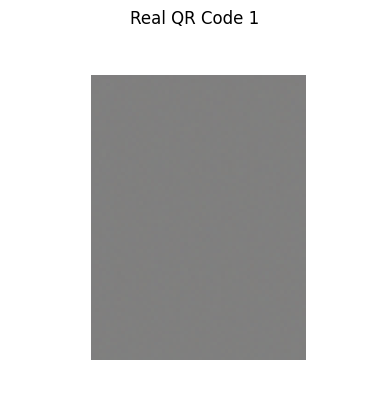

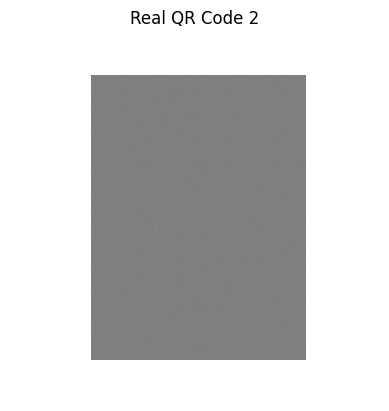

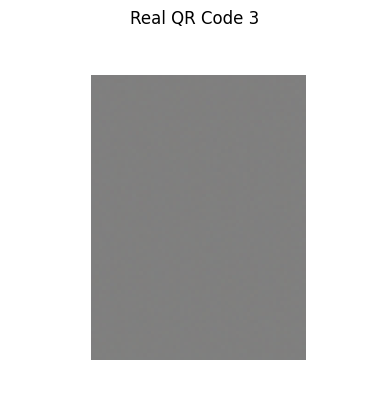

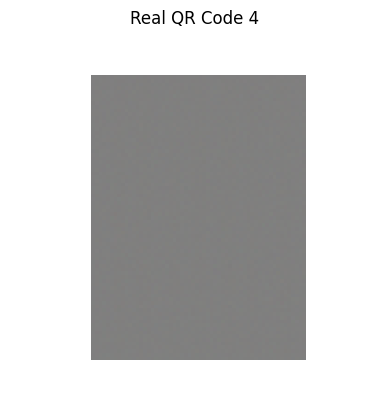

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# Load and display a real QR code from the training dataset
def display_real_qr_codes(n_samples):
    for i in range(n_samples):
        image_path = f'qr_codes/generated/qr_code_{i}.png'
        image = load_img(image_path, target_size=(100, 100))
        image_array = img_to_array(image) / 255.0
        plt.imshow(image_array)
        plt.axis('off')
        plt.title(f'Real QR Code {i}')
        plt.show()

# Display first 5 QR codes
display_real_qr_codes(5)


In [ ]:
### Summary:
In this lab, we successfully implemented a Generative Adversarial Network (GAN) to create synthetic QR codes
By generating a dataset of QR codes and training the GAN, we achieved a generator capable of producing QR codes that closely resemble real ones while retaining the embedded messages.
Through hands-on experience with building and optimizing both the generator and discriminator, we deepened our understanding of GANs and their applications in synthetic data generation. 
The results demonstrate the potential of GANs in various fields, including data augmentation and creative applications.
